In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [71]:
Nmics = 64
Nsamp = 200

src = (0,0)
pitch = 0.1
dist_per_samp = 0.1
C = 2
SincP = 5.0

mics = []
y_mics = int(Nmics/2)

#for positions of mic
for i in range(-y_mics,y_mics+1):
    y = pitch * i
    mics.append((0,y))  # for odd number of mics
if Nmics % 2 == 0:  #for even number of mics
    mics.pop(y_mics)
mics = np.asarray(mics)

obstacle = (3, -1)

In [72]:
tmax = Nsamp * dist_per_samp #maximum range of time

#generating time/x axis values
t = np.linspace(0,tmax,Nsamp)

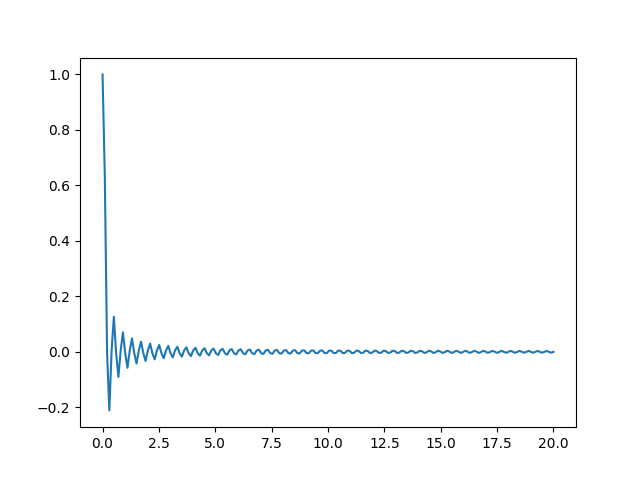

In [73]:
%matplotlib ipympl

#for sinc pulse generation
def wsrc(t):
    return np.sinc(SincP * t)

#source generated sinc pulse
signal = wsrc(t)
plt.plot(t,signal)
# plt.savefig('source_original.jpg')

#### QUESTION
- To get the smooth graphs for sinc pulse, I increased the Nsamp value to 1000 fixing the dist_per_samp (one could als decrease dist_per_samp fixing the Nsamp to achieve the same).

- If Nsamp is less, it takes very less samples, and the output plot is not accurate( as les data points).
- The parameter to be changed is SincP value. For **sinc pulse 1**, SincP is `2` and for **sinc pulse 2**, SincP is `8`. Increasing the SincP value makes the signal die faster.

In [74]:
#generalised distance function
def distance(src,pt):
    return np.sqrt((src[0] - pt[0])**2 + (src[1] - pt[1])**2)

#calculating total distance forward + reflected (received by the mic)
def dist(src, pt, mic):
    #distance from src to point
    d1 = distance(src,pt)
    #distance from point to mic
    d2 = distance(pt,mic)
    return d1+d2


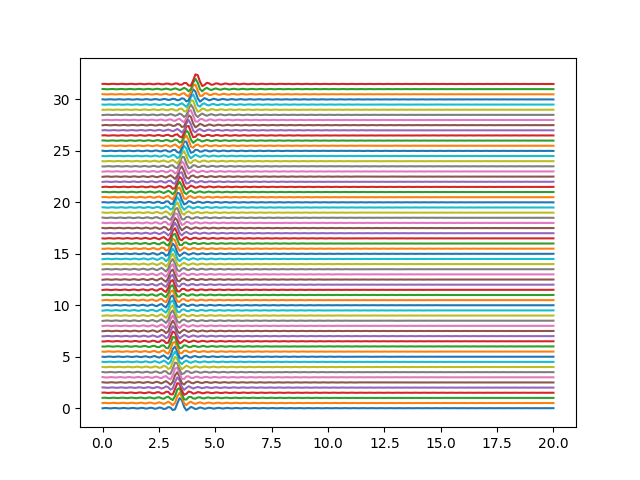

In [75]:
%matplotlib ipympl

#shifted wave generation
def shift_wave(src, pt, mic,t):
    d = dist(src,pt,mic)
    return wsrc(t-d/C)

#calculating shifted wave received by each mic after reflecting from the obstacle
mic_waves = [shift_wave(src,obstacle,mic,t) for mic in mics]
waves = np.array(mic_waves)

#plotting with offset along y-axis
for i,r in enumerate(mic_waves):
    plt.plot(t, r+i*0.5)

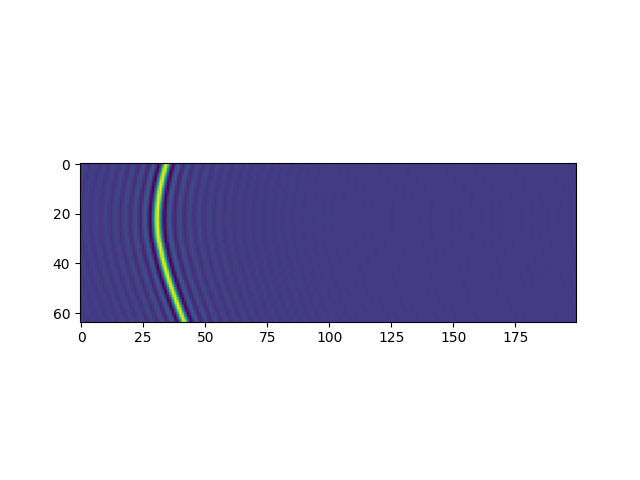

In [76]:
%matplotlib ipympl

#heat wave generation
plt.imshow(waves,cmap = 'viridis')
# plt.savefig('reflectedhw_original.jpg')

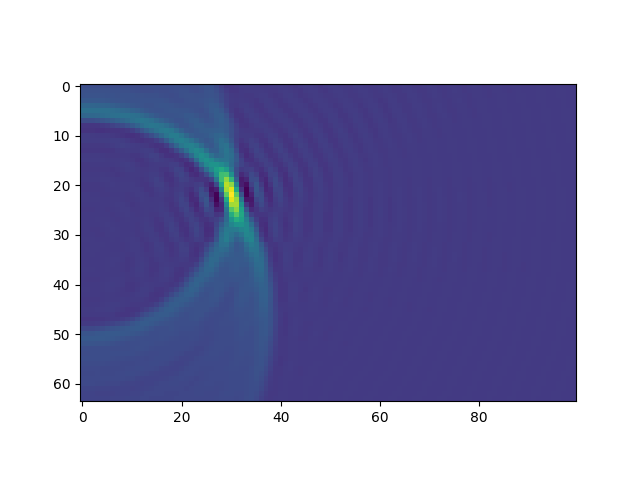

In [77]:
%matplotlib ipympl

#delay calculation
def timedelay(src,pt):
    return distance(src,pt)/C

#array used for plotting
plot_array = []
for j in mics:
    #for reflected wave by each (i,j) on the grid
    rwaves = []
    for i in range(Nsamp//2):
        #to calculate the superpositioned wave
        super_wave = 0
        for k in mics:
            #time delay for each mic
            T = timedelay(src,(i*dist_per_samp,j[1])) + timedelay((i*dist_per_samp,j[1]),k)
            #superposing all the reflected waves received by mics to get the final wave for each (i,j)
            super_wave += shift_wave(src,obstacle,k,t+T)
        #we need only the amplitude at 0th instant; as we compare the final superimposed wave with source amplitude
        rwaves.append(super_wave[0])
    plot_array.append(rwaves)
plt.imshow(plot_array)
# plt.savefig('reconstructed_64100.jpg')

- I am considering that the grid has y-coordinates similar to those of mics and x- coordinates in the range of Nsamp.
- `rwaves` is used to store reflected waves due to (i,j) point on the grid.
- `super_wave` is used to superposition all the waves - waves received by all the mics due to single point (i,j) on the grid.
- Here the trick is we need not consider all the samples of `super_wave`. We will compare the amplitudes at the instant 0 as the source has highest amplitude at 0.
- When the amplitude matches with the source amplitude at 0 instant, thats where the obstacle os present.
- `plot_array` in the end becomes a 64 * 200 matrix.

#### QUESTION

No, it doesn't make sense to reconstruct upto Nsamp.

Consider an obstacle situated after Nsamp/2, when we calculate the delay, the distance travelled by it would exceed the Nsamp. 
- The reflected waves received by mics would have peaks beyond Nsamp. It happens that all the peaks are not seen in the range of Nsamp. 
- And when we try to plot them, the obstacle position would not be accurate rather scattered. 
- The randomness of obstacle increases comparatively.

So, the obstacle can only take positions before Nsamp/2.

#### QUESTION

The (x, y) coordinates corresponding to the maximum amplitude (yellow colour) is approximately (30, 22).
This is the correct expected position for the given obstacle.  The obstacle is at (3,-1) actually.
- For x coordinate : 
    - The distance per sample for each Nsamp is 0.1. 
    - It means, if Nsamp is 200, effectively we have 20 units on x-axis. 
    - 30 on Nsamp would actually correspond to 3 on x-axis, which is consistent. 
- For y coordinate :
    - The mics are placed in reverse order i.e. 1st mic is at -3.2 which is 0 on the y-axis and the 64th mic which is at 3.2 corresponds to 64 on the y-axis.
    - ith mic is at (0.1 * i) - 3.2 (0.1 is nothing but pitch).
    - so -1 on y-axis should correspond to (-1 + 3.2) * 10 = 22 in the mics.

#### QUESTION
The maximum obstacle coordinates:
- x - coordinate should be in the range of (0, Nsamp * dist_per_samp/2) i.e. (0,10) for proper estimation of obstacle.
- y - coordinate should be in the range of (-no. of mics * pitch /2, no. of mics * pitch /2) i.e (-3.2, 3.2).
    - If we consider the coordinates outside this range, we will not be able to differentiate between the obstacles that are equally away from the central line i.e. midway between the mics. The delays would be identical, making it difficult to identify the position of obstacle, if it's above or below.

#### QUESTION

- If C increases, the image becomes more scattered.
- If C decreases, the image becomes more sharper.
This is because,
- Decreasing C, would increase time delays. It means for the points in a neighbourhood, the time delays become finer, can be distinguished more easily.
- This gives more accurate plots and better obstacle approximation.

#### QUESTION

If no. of mics decreases:
- While reconstructing, there are very less no. of waves to be superposed. 
- There is als a chance that the obstacle falls out of the range of y - axis.

- This leads to difficulty in estimating the obstacle position.

If no. of mics increases:
- This helps in better reconstruction to a certain point.
- After certain point, increasing mics would only lead to extra computational work i.e. the distance from obstacle increases to the mics in the edges. The reflected waves due to these mics don't contribute much to the superposition.

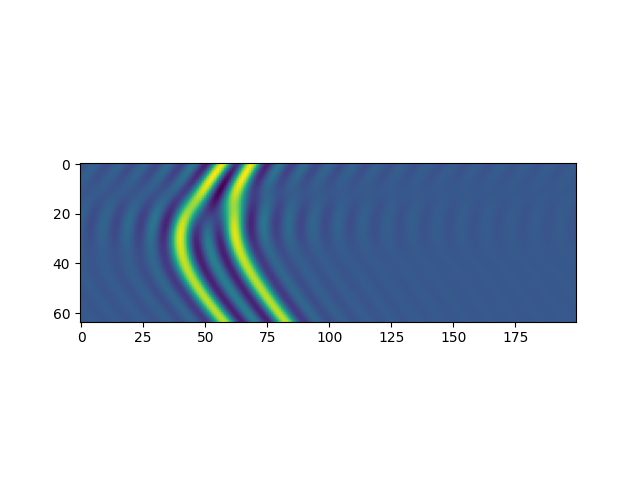

In [78]:
%matplotlib ipympl
#loading data
array1 = np.loadtxt('rx2.txt')
plt.imshow(array1)
plt.savefig('r21.jpg')

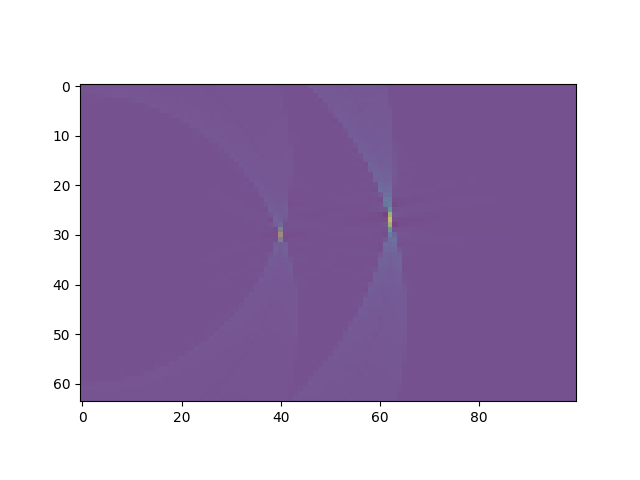

In [79]:
%matplotlib ipympl

C = 0.5

#obstacle postions from the graph above
obstacles = [(4,-0.2),(6.2,-0.5)]

for o in obstacles:
    #for each obstacle we need to plot
    plot_array = []
    for j in mics:
        rwaves = []
        for i in range(Nsamp//2):
            super_wave = 0
            for k in mics:
                T = timedelay(src,(i*dist_per_samp,j[1])) + timedelay((i*dist_per_samp,j[1]),k)
                super_wave += shift_wave(src,o,k,t+T)
            rwaves.append(super_wave[0])
        plot_array.append(rwaves)
    plt.imshow(plot_array,alpha = 0.5)#transperancy to see a the obstacles
# plt.savefig('r2.jpg')

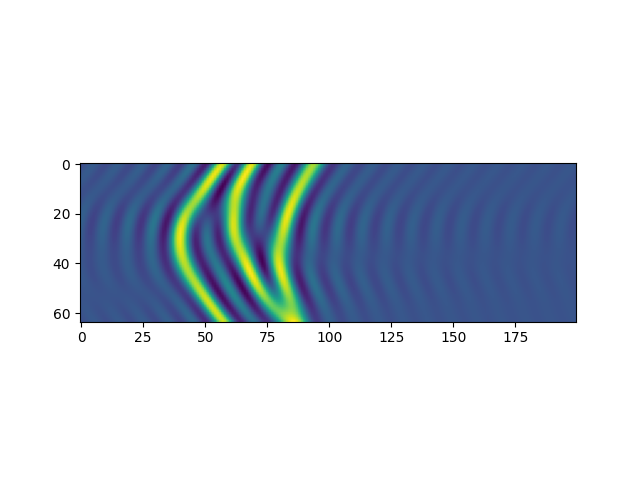

In [80]:
%matplotlib ipympl
array2 = np.loadtxt('rx3.txt')
plt.imshow(array2)
# plt.savefig('r32.jpg')

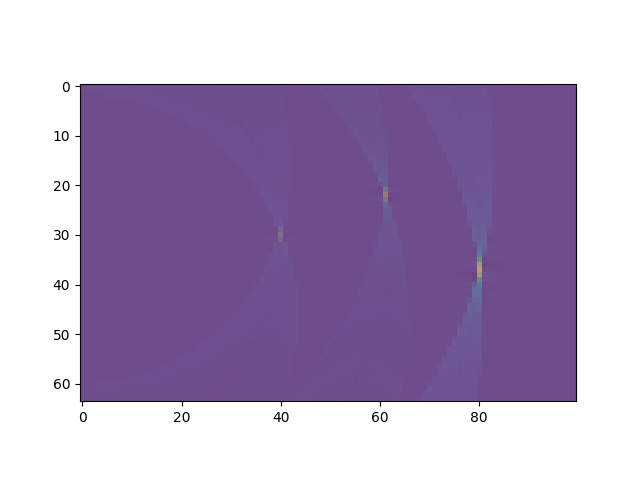

In [81]:
%matplotlib ipympl

C = 0.5

obstacles = [(4,-0.2),(6.1,-1),(8,0.6)]

for o in obstacles:
    plot_array = []
    for j in mics:
        rwaves = []
        for i in range(Nsamp//2):
            super_wave = 0
            for k in mics:
                T = timedelay(src,(i*dist_per_samp,j[1])) + timedelay((i*dist_per_samp,j[1]),k)
                super_wave += shift_wave(src,o,k,t+T)
            rwaves.append(super_wave[0])
        plot_array.append(rwaves)
    plt.imshow(plot_array, alpha = 0.4)
# plt.savefig('r3.jpg')

#### FOR THE TEST CASES:
- I plotted the data given using imshow.
- Found the obstacle positions i.e the protruded point in the curve is obstacle position. Repeated this for each curve to get all the obstacle positions.
- Then I used similar logic(for one obstacle) to find obstacle positions.